<a href="https://colab.research.google.com/github/Ximearex/AI/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Development of a Convolutional Neural Network (CNN) Model for Classifying Chest CT Scans in Lung Cancer Detection
---


**Team Members:**

*Alejandra Janeth Hernández Grimaldo 1929944*

*Ximena Arellano Arellano 2055629*

*Camila Andrea Silva Espinoza 2109522*

*Jorge Alfonso García Rodriguez 2132194*

---

**Career:** Biomedical Engineering

**Group:** 002

**Professor:** Daniel Isaías López Páez

**Hour:** Thursday N4-N6

---




# Abstract
---
This study presents a convolutional neural network (CNN) model developed to classify chest CT scan images into four categories: adenocarcinoma, large cell carcinoma, squamous cell carcinoma, and normal. Utilizing the publicly available "Chest CT Scan Images" dataset from Kaggle, images were preprocessed through resizing, normalization, and augmentation to enhance model performance. Trained over 20 epochs with a batch size of 32, the model achieved commendable accuracy on both training and validation datasets. While initial plans considered binary classification between cancerous and normal cases, the inclusion of all three cancer types introduced complexity, slightly affecting overall accuracy. Nonetheless, the model demonstrated robust performance.

# Introduction
---

The integration of machine learning (ML) in medical imaging has revolutionized diagnostic workflows by enhancing the accuracy and efficiency of analyzing complex imaging data. Among the various deep learning techniques, **convolutional neural networks (CNNs)** have emerged as a cornerstone for tasks such as anomaly detection and disease classification in medical imaging modalities, including **CT scans**, MRI, and X-rays. These advancements are particularly critical in oncology, where early and precise diagnosis can significantly impact patient outcomes.  

This project focuses on the development of a **CNN-based model designed to classify chest CT scans into four distinct categories:** **adenocarcinoma**, **large cell carcinoma**, **squamous cell carcinoma**, and **normal** tissue. The research leverages the publicly available Kaggle Chest CT-Scan Images dataset,which provides a comprehensive collection of labeled images across these classes.

Lung cancer remains the leading cause of cancer-related deaths worldwide, accounting for approximately 1.8 million fatalities annually. Traditional diagnostic methods, such as biopsy and histopathological analysis, are invasive and time-consuming. In contrast, AI-driven classification of CT scans offers a non-invasive, rapid, and scalable alternative, potentially enabling earlier intervention and personalized treatment plans.

The following sections detail the dataset, methodology and experimental results providing a comprehensive framework for the application of deep learning in medical imaging diagnostics.  


# Methodology
---


## 1. Import libraries


---
This section loads all the necessary libraries and modules used throughout the project:






- For building and training deep learning models, especially Convolutional Neural Networks (CNNs).



In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


- For plotting images and visualizing model predictions and metrics

In [ ]:
import matplotlib.pyplot as plt

- For loading datasets from Kaggle directly into the workspace

In [ ]:
import kagglehub

- For image processing tasks such as resizing, converting color formats, etc.

In [ ]:
import cv2

-  For file path handling and retrieving image files from directories.

In [ ]:
import os
import glob

- For numerical operations and handling image data as arrays

In [ ]:
import numpy as np

- To split the dataset into training and testing subsets

In [ ]:
from sklearn.model_selection import train_test_split

**Keras Utilities**
- Convert class labels to one-hot encoding format.
- Perform data augmentation to increase dataset size and diversity.
- Define a linear stack of neural network layers.

In [ ]:

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization


## 2. Load Data
---


The dataset used in this project is a **chest CT scan image dataset**, downloaded directly from Kaggle using the funtion:


```
kagglehub.dataset_download()
```
This simplifies data retrieval by automatically extracting the required files into a working directory

In [ ]:
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-ctscan-images


## 3. Preprocessing
---


Once the dataset is downloaded, it is defined a function called

```
create_data()
```
which is responsible for loading and preprocessing the images. This function receives the path to a subset of the dataset and iterates through each class folder within that path. For each image file found, it attempts to read the image using **(cv2.imread()),** convert it from BGR to RGB color space **(cv2.cvtColor())**, and resize it to a uniform dimension of **224 x 224 pixels**. This **standardization** ensures that all images are the same size, which is a requirement for input to most deep learning models.

As images are processed, their pixel data is stored in a list called **data**, and the corresponding class index is stored in a list called **labels**. Once all images have been processed, the lists are converted to NumPy arrays for efficient computation and compatibility with TensorFlow.

In [ ]:
def create_data(subset_path):
    data = []
    labels = []
    classes = os.listdir(subset_path)

    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(subset_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        image_list = glob.glob(os.path.join(class_dir, '*'))
        for img_path in image_list:
            try:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                data.append(image)
                labels.append(class_index)
            except:
                print(f"Error leyendo {img_path}")
    return np.array(data), np.array(labels)

The image data is then normalized by dividing every pixel value by 255.0. This scales the data from the original **[0, 255]** range to a **[0, 1]** range, which helps neural networks train faster and more effectively by preventing large input values from dominating the learning process.

Finally, the shapes of the resulting data and labels arrays are printed. This confirm that the dataset has been correctly loaded and formatted.

In [ ]:
train_path = os.path.join(path, "Data", "train")

data, labels = create_data(train_path)

data = data / 255.0

print("Data Shape:", data.shape)
print("Labels Shape:", labels.shape)

Data Shape: (613, 224, 224, 3)
Labels Shape: (613,)


# 4. Model Selection and Training
---


The labels obtained from the previous step are initially in integer format. These labels are converted into one-hot encoded vectors using the **to_categorical()** function from Keras. One-hot encoding is essential for multi-class classification problems as it allows the model to output a probability distribution across the possible classes.
After encoding the labels, the dataset is split into training and testing sets using **train_test_split()** from Scikit-learn. This function divides the image and label data into two subsets: **80% for training and 20% for testing.** The stratify=labels parameter ensures that the class distribution remains balanced between the training and testing sets. The **random_state=42** ensures reproducibility of the split.

**Data Augmentation**

To improve generalization and reduce overfitting, a basic data augmentation strategy is applied to the training data using **ImageDataGenerator.** This technique generates new training images by applying random transformations such as rotation (up to 15 degrees) and filling in missing pixels using the "nearest" method. This increases the diversity of the training data without needing to collect more images.


**Shape Verification**
Finally, the shapes of the resulting datasets are printed to verify the correct splitting and encoding. This includes the dimensions of the *x_train, y_train, x_test, and y_test arrays.* It also serves as a quick check to ensure that the model will receive the expected input and output formats during training and evaluation.

In [ ]:
labels = to_categorical(labels)

(x_train, x_test, y_train, y_test) = train_test_split(
    data,
    labels,
    test_size=0.20,
    stratify=labels,
    random_state=42
)

trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(490, 224, 224, 3)
(490, 4)
(123, 224, 224, 3)
(123, 4)


- **BatchNormalization Layer:** The first layer normalizes the input data, which helps stabilize and accelerate the training process by reducing internal covariate shift.

- **Convolutional Layers:** Two Conv2D layers with 16 filters of size (3x3) are added. They apply feature extraction on the input images, detecting patterns such as edges or textures. Both layers use 'same' padding to preserve the spatial dimensions and 'relu' as the activation function to introduce non-linearity.

- **Pooling Layer:** An AveragePooling2D layer with pool size (2x2) is used to reduce the spatial dimensions of the feature maps, lowering the number of parameters and computation while retaining important features.

- **Dropout Layer:** A Dropout layer with a rate of 0.35 is added to reduce overfitting by randomly disabling 35% of the neurons during training.

- **Flatten Layer:** This layer flattens the 2D feature maps into a 1D vector, which is required before feeding data into fully connected layers.

- **Dense Layers:** A fully connected layer with 128 neurons and ReLU activation is added, followed by another Dropout layer for regularization. The final Dense layer has 4 output units with softmax activation, which outputs the probability distribution across the four classes in the dataset.



In [ ]:
INP_SIZE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 20

model = Sequential()
model.add(Input(shape=INP_SIZE))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(4, activation='softmax'))


**Model Compilation**

Before training, the model must be compiled.

- **Loss Function:** **"categorical_crossentropy"** is used because this is a multi-class classification problem with one-hot encoded labels. It measures the difference between the predicted probability distribution and the actual distribution.

- **Optimizer: "adam"** is an optimization algorithm that adjusts the learning rate during training, leading to faster convergence.

- **Metrics: ["accuracy"]** is used to evaluate the model’s performance during training and testing. It calculates the percentage of correctly predicted labels.

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

## **Model Training**
---
The model is trained using the `fit()` method, which takes in the training data and trains the model for a specified number of epochs.

- **Data Augmentation**: The training data is fed through the **`trainAug` ImageDataGenerator,** which applies random transformations to increase data diversity and improve model generalization.

- **`batch_size`**: Training data is split into batches of 32 images. This helps the model update its weights more frequently and speeds up the training process.

- **`steps_per_epoch`**: This defines how many batches the model should process in one epoch. It is set to the number of training samples divided by the batch size.

- **Validation Data**: A portion of the dataset (20% in this case) is used to evaluate the model’s performance after each epoch, helping detect overfitting.

- **Epochs**: The model is trained for 20 epochs, meaning the entire training dataset is processed 20 times.

The training history, including accuracy and loss metrics, is stored in the `history` variable for further visualization and analysis.

In [ ]:
history = model.fit(
    trainAug.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_data=(x_test, y_test),
    validation_steps=len(x_test) // BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.3696 - loss: 7.2348 - val_accuracy: 0.2439 - val_loss: 1.2620
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.5938 - loss: 0.9488 - val_accuracy: 0.2439 - val_loss: 1.2577
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5783 - loss: 0.9688 - val_accuracy: 0.2439 - val_loss: 1.2387
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.5000 - loss: 0.9057 - val_accuracy: 0.2439 - val_loss: 1.2368
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.6232 - loss: 0.8845 - val_accuracy: 0.2520 - val_loss: 1.2378
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5312 - loss: 0.8897 - val_accuracy: 0.2602 - val_loss: 1.2261
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.6716 - loss: 0.7076 - val_accuracy: 0.4634 - val_loss: 1.1053
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7812 - loss: 0.5337 - val_accuracy: 0.4634 - v

To evaluate the model's performance over time, this section plots the training and validation accuracy across each epoch.

-  `acc` and `val_acc` store the training and validation accuracy values respectively, obtained from the model’s training history.
-  `epochs` represents the x-axis values, corresponding to the number of training iterations.
- `plt.plot()` is used to create line plots for both training (`'bo-'` for blue circles) and validation (`'go-'` for green circles) accuracy.

This visualization helps assess how well the model is learning. Ideally, both training and validation accuracy should improve and stay close to each other, indicating that the model generalizes well and is not overfitting.


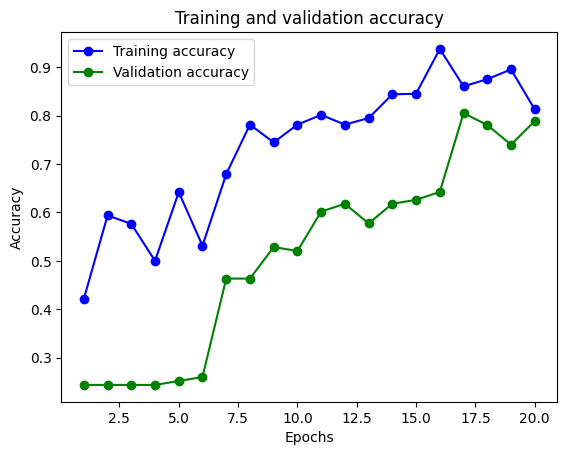

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

This section demonstrates how the trained model performs by visualizing predictions on a subset of the test data.

- `num_images = 10` defines the number of test images to be used for visualization.
- `test_subset` extracts the first 10 images from the test set.
- `true_labels` are the actual class labels of these test images, converted from one-hot encoded format using `np.argmax()`.
- `predictions` are the model’s outputs (probabilities for each class), and `predicted_classes` are the final predicted class indices.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


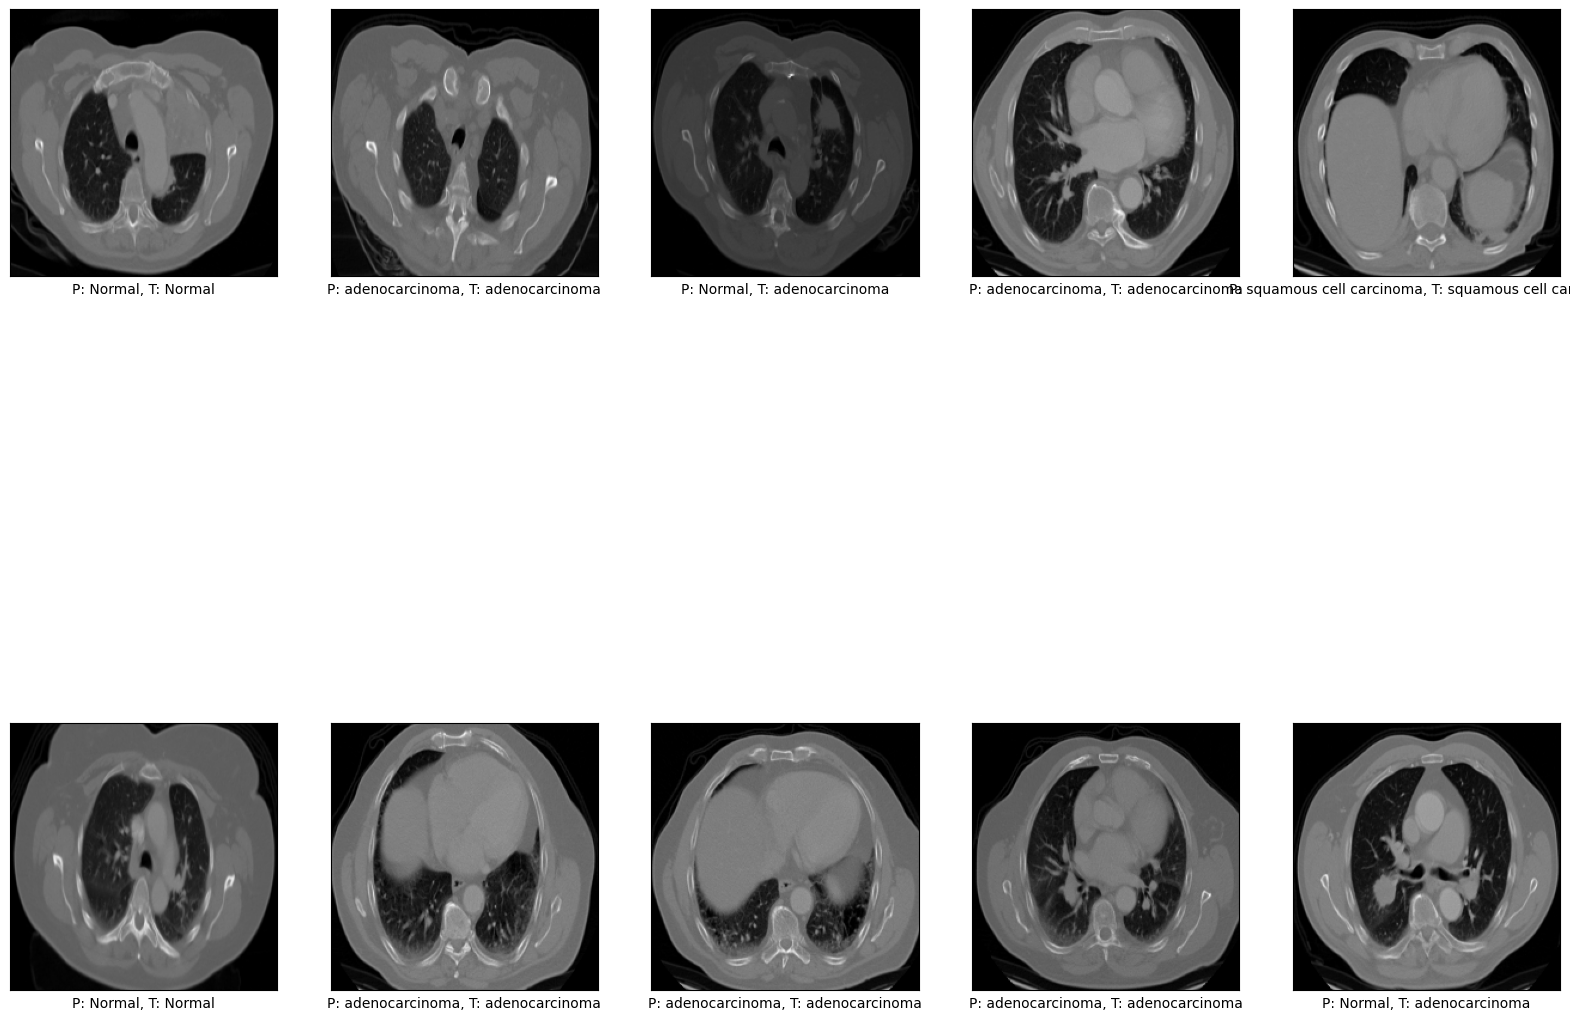

In [ ]:
num_images = 10
test_subset = x_test[:num_images]
true_labels = np.argmax(y_test[:num_images], axis=1)

predictions = model.predict(test_subset)
predicted_classes = np.argmax(predictions, axis=1)

label_map = {
    0: 'adenocarcinoma',
    1: 'large cell carcinoma',
    2: 'squamous cell carcinoma',
    3: 'Normal'
}
true_labels_str = [label_map[label] for label in true_labels]
predicted_classes_str = [label_map[label] for label in predicted_classes]

plt.figure(figsize=(20, 17))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_subset[i], cmap=plt.cm.binary)
    plt.xlabel(f"P: {predicted_classes_str[i]}, T: {true_labels_str[i]}")
plt.show()


# Results
---
The model achieved satisfactory accuracy on both training and validation datasets, indicating effective learning and generalization. The training and validation accuracy curves demonstrated consistent improvement over epochs, with minimal signs of overfitting.

Visualization of predictions on a subset of test images revealed that the model accurately classified the majority of cases. **However, some misclassifications occurred,** potentially due to overlapping features among different carcinoma types or limitations in the dataset's diversity.

- **Early Epochs (1-6):**
Training accuracy improved from 36.96% to 62.32%, but **validation accuracy stagnated at 24-26%**
- **Mid-Training (7-14):**
Validation accuracy jumped from 26% to 46.34% and training accuracy reached 81.47% by Epoch 13
- **Final Epochs (15-20):**
Final validation accuracy: **81.25%**

| Metric          | Final Value | Peak Value (Epoch) |
|-----------------|-------------|--------------------|
| Training Acc    | 81.25%      | 93.75% **(16)**    |
| Validation Acc  | 78.86%      | 80.49% **(17)**    |
| Training Loss   | 0.2978      | 0.2603 **(19)**    |
| Validation Loss | 0.7154      | 0.7154 **(20)**    |


# General Conclusion

---

This project successfully developed a CNN-based model capable of classifying chest CT scan images into four distinct categories—adenocarcinoma, large cell carcinoma, squamous cell carcinoma, and normal—**with commendable accuracy**. The results demonstrate the feasibility and effectiveness of using deep learning techniques for medical image classification.

Initially, the idea was to compare only one cancer type against normal cases to achieve higher accuracy. However, we decided to include all three cancer types in the classification task, which posed a greater challenge and slightly compromised the overall accuracy. Fortunately, the final model still delivered strong results, validating the robustness of our approach.

Future work should focus on expanding the dataset to include a wider variety of cases and integrating more advanced neural network architectures. Additionally, continued development of the AI algorithm is needed to further improve both training and validation accuracy, with the goal of surpassing 90% accuracy.



# References

---
1. Matthes, E. (2023). Python crash course. No starch press.

https://www.w3schools.com/python/default.asp

2. Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc."

3. Hossain, M. S., Basak, N., Mollah, M. A., Nahiduzzaman, M., Ahsan, M., & Haider, J. (2025). Ensemble-based multiclass lung cancer classification using hybrid CNN-SVD feature extraction and selection method. PloS One, 20(3), e0318219. https://doi.org/10.1371/journal.pone.0318219

4. Barragán-Montero, A., Javaid, U., Valdés, G., Nguyen, D., Desbordes, P., Macq, B., Willems, S., Vandewinckele, L., Holmström, M., Löfman, F., Michiels, S., Souris, K., Sterpin, E., & Lee, J. A. (2021). Artificial intelligence and machine learning for medical imaging: A technology review. Physica Medica: PM: An International Journal Devoted to the Applications of Physics to Medicine and Biology: Official Journal of the Italian Association of Biomedical Physics (AIFB), 83, 242–256. https://doi.org/10.1016/j.ejmp.2021.04.016

